#1. What is CNN
CNN, or Convolutional Neural Network, is a type of deep learning artificial neural network specifically designed for image and video recognition tasks. It automatically learns and extracts important features from large amounts of data and uses these features to make predictions, such as object classification and detection, and scene segmentation.

The key concept behind CNNs is the use of convolutional layers, which scan an input image to detect specific features such as edges, corners, and shapes. These convolutional layers are followed by activation functions and pooling layers, which help simplify the features and reduce the spatial dimensions of the data. The features are then passed through fully connected layers, which make the final prediction.

The unique architecture of CNNs, specifically the use of convolutional layers and pooling, allows it to effectively process images represented as 2D matrices, making it highly useful for image classification tasks. It can handle images that have been translated, rotated, scaled, and changes in perspective, making it a robust solution for image recognition challenges.

In conclusion, CNNs have been very successful in many computer vision and image classification tasks and are widely used in both industry and academia. With its specialized design and ability to effectively process image data, CNNs have become a critical tool in solving complex image recognition challenges.

#2. What is LSTM
LSTM, or Long Short-Term Memory, is a powerful type of Recurrent Neural Network (RNN) architecture used in deep learning. Unlike traditional RNNs, LSTMs are designed to handle the issue of vanishing gradients and are better suited for sequence prediction problems, where the network needs to understand the context and meaning of the input data over a long sequence of time steps.

LSTMs have a unique memory cell structure that allows them to maintain information for longer periods of time and selectively forget or retain information as needed. This is achieved through the use of gates, such as input, forget, and output gates, which control the flow of information in and out of the memory cell. This selective memory mechanism allows the network to make informed predictions based on relevant information.

LSTMs are widely used in various applications, such as speech recognition, language translation, sentiment analysis, stock price prediction, and video classification. These tasks require the network to understand the context and meaning of the input data, and LSTMs provide the ability to maintain and process relevant information over a long sequence of time steps, making them a highly effective choice.

In conclusion, LSTMs are a type of RNN architecture designed to handle long-term dependencies and are commonly used in deep learning tasks that involve sequential data. With their unique memory cell structure and gates, LSTMs have proven to be an effective solution for sequence prediction problems and have seen wide adoption in industry and academia.

#3. Image Caption Generator Model
So, to make the image caption generator model, I  will be merging these architectures. It may also be called as CNN-RNN model.
1. CNN is used for extracting features from the image. I will use the pre-trained model VGG16.

  I am utilizing a pre-trained model called VGG16 for image detection, which was developed by the Visual Geometry Group at the University of Oxford. The "16" in the name refers to the number of layers in the model, which includes 13 convolutional layers and 3 fully connected layers. VGG16 is known for its high accuracy and is often used as a foundation for other image recognition tasks. I selected this model because it is relatively small and can be trained quickly. The model is built on a CNN architecture, and it uses 3x3 convolutional layers stacked on top of each other in increasing depth. Additionally, it utilizes max pooling layers to decrease volume size and has three fully connected layers with 4096 nodes each, followed by a SoftMax classifier.

2. LSTM will use the information from CNN to help generate a description of the image.

#4. Dataset for Image Caption Generator
For this project I will be utilizing the Flicker_8k dataset which contains more than 8000 images with 5 sentences each describing the corresponding image. I have mounted the dataset via Google drive where the images are under the images folder and the texts are under captions folder. https://www.kaggle.com/datasets/adityajn105/flickr8k

# 5. Importing necessary Modules

In [2]:
import os # Handling the files(The os module provides a way to interact with the operating system in a platform-independent manner. )
import pickle # Used to store the numpy features. eg- we will be extracting the image features, to store the features it is used or else the entire process and to be redone
import numpy as np
from tqdm.notebook import tqdm # Used to show the progress bar, giving the users UI to track how much data has processed till now.

from keras.applications.vgg16 import VGG16 #Importing the vgg16 model from keras
from keras.applications.vgg16 import preprocess_input #preprocess_input which is used to pre process the given image inorder to extract the feactures before feeding it to the model
from keras_preprocessing.image import load_img #load_img function is used for loading an image from file as a pil image or pil image object
from keras_preprocessing.image import img_to_array #img_to_array is used to convert pil image instance to numpy array so that our model can understand the image. Basically converting the image into numerical as computer only unerstands numbers 
from keras_preprocessing.text import Tokenizer #  The tokenizer class is used to preprocess text data and convert it into unique numerical data and then represents the text as a sequence of integers that can be fed into a machine learning model.
from keras_preprocessing.sequence import pad_sequences # Used to pad sequences of values to the same length, by adding zeros or truncating values at the end
from keras.models import Model # With this import, I have access to the Model class, which is the core class for creating and training models in Keras. 

from keras.utils import to_categorical, plot_model # This will give clear representaion of the model in terms of image, making easy to view the architecure of the model
from keras.layers import  Input, Dense, LSTM, Embedding, Dropout, add

BASE_DIR = '/content/drive/MyDrive/Flicker_8k'
IMG_DIR = '/content/drive/MyDrive/Flicker_8k/Images'


#6. Loading the VGG16 Model(Restructure)
The below code imports the VGG16 model from the "keras.applications" module and creates an instance of the model. The code removes the last layer of the VGG16 model, this is done to remove the fully connected layer which is responsible for classification, since I only want to extract features from the images and not classify them. The code then creates a new model which takes the input of the VGG16 model and the output of the second last layer of the VGG16 model, this is done to use the model as a feature extractor.


In [3]:
model = VGG16() # Loading the model
# Restructuring the model
model = Model(inputs = model.input, outputs = model.layers[-2].output) # I dont need the fully connected(prediction) layer of the vgg model which is classificaiton layer. Just need the previous layers to extract the feature results
print(model.summary()) # printing the model without the last layer

553467096/553467096 [==============================] - 24s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

#7.Feature Extraction
The above code is for extracting features from a set of images using a pre-trained VGG16 model. It starts by defining an empty dictionary "features" that will store the features of each image. The path to the directory where the images are stored is joined with the constant string IMG_DIR to form the "directory" variable. The code then uses the tqdm library to loop over the filenames in the directory, which represent the images. For each image, the path to the image is constructed by joining the directory path and the filename. The image is then loaded using the load_img function from the Keras library and resized to (224,224) as required by the VGG16 model. The image is then converted to a numpy array using the img_to_array function and reshaped to have the shape (1,224,224,3), where the first dimension is the batch size, and the last three dimensions are the height, width and number of channels of the image, respectively. The image is then preprocessed using the preprocess_input function from the VGG16 model to align it with the format expected by the model. The features of the image are then extracted using the predict method of the VGG16 model, and stored in the "features" dictionary using the image id (obtained by splitting the filename on "." and taking the first part) as the key and the extracted features as the value. 

In [ ]:
# Extract features from image
features = {}
directory = os.path.join(BASE_DIR, "Images")
# Listdir helps in searching through a given path for all the files on the directory
for img_name in tqdm(os.listdir(directory)): #loop to go through each of the image in the 30kdataset
  img_path = directory + "/" + img_name # Getting the whole path of the image
  image = load_img(img_path, target_size=(224,224)) # Used to load an image file and resize it to a specific target size (224,224), the output of this function is a PIL.Image object, which represents the resized image.
  image = img_to_array(image) # Converting the resized image pixel to numpy array
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) #The given code is reshaping an image into a 4-dimensional array. The reshape method is being used to change the shape of the image array(1, height, width, depth)
  image = preprocess_input(image) # Used to preprocess the image so that it can be used as input to the VGG16 model.
  feature = model.predict(image, verbose=0) # Verbose =0 means no progress bar will be displayed
  image_id = img_name.split(".")[0] # The code is taking the file name of the image, for example, "dog.jpg" and splitting it by the "." character, resulting in a list ['dog', 'jpg']. Storing dog as the imageid
  features[image_id] = feature # This line of code is storing the feature vector obtained from the VGG16 model's prediction for a given image in the "features" dictionary, with the key as the "image_id".


  0%|          | 0/8091 [00:00<?, ?it/s]

# 8. Storing the Features
The above code is used to store the image features in a pickle file. The features dictionary, which is the output of the VGG16 model, is saved to a pickle file. The file name is "Extracted_Features.pkl" and it is saved in the IMG_DIR directory. The "wb" argument in the open function means write binary mode, which is used to save the features dictionary. 

In [ ]:
pickle.dump(features, open(os.path.join(BASE_DIR, "Extracted_Features.pkl"), "wb")) # Storing the features in the same path as source img. The "wb" argument specifies that the file should be opened in write binary mode, which is necessary when using the pickle module to save objects.



---



---



#9. Loading the Features
The code opens a pickle file "Extracted_Features.pkl" from the directory IMG_DIR in binary read mode ("rb") and loads the content of the pickle file into a dictionary named "features". The loaded data is now stored in the dictionary and can be used for further processing. THis saves time as well as computing as it can be used again and again without having to stop and ponder.

In [4]:
with open (os.path.join(BASE_DIR, "Extracted_Features.pkl"), "rb") as f:
  features = pickle.load(f)



---



---



# 10. Loading the Captions
This code opens a file called "captions.txt" located at "BASE_DIR/content/drive/MyDrive/Imaze.AI/Flicker_30K/captions.txt". The "r" argument specifies that the file should be opened in read-only mode, and the contents of the file are read and stored in the "captions" variable.

In [5]:
with open(os.path.join(BASE_DIR, "/content/drive/MyDrive/Flicker_8k/captions.txt"), "r") as f:
  captions = f.read()



---



---



#11. Mapping the image to its corresponding captions
This code below is used to create a dictionary mapping which maps image IDs to their corresponding captions.

The code starts by initializing an empty dictionary mapping. Then, it loops over each line in the captions variable. The captions variable is first split into individual lines by the newline character \n.

For each line, the code splits the line into two tokens using the comma as a separator. The first token (token[0]) is the image ID, and the rest of the tokens (token[1:]) are the captions for that image.

The code then removes the extension from the image ID (e.g. ".jpg") by splitting the img_id variable by the period (.) character and taking the first part (img_id.split(".")[0]).

Next, the code converts the list of captions into a single string by using the join method with an empty string as a separator.

Finally, the code checks if the image ID is already in the mapping dictionary. If it's not, the code creates an empty list for that image ID in the mapping dictionary. In either case, the code adds the caption to the list of captions for that image ID.

Overall, this code block is used to create a dictionary that maps image IDs to their corresponding captions, where each image ID has a list of captions associated with it.

In [6]:
mapping = {} #blank dictonary to store images with its corresponding texts
for line in tqdm(captions.split("\n")): # Going through each line in capitons variable, splitted by a new line. Each indivusaual line is treated as one
  token = line.split(",") # Each line stored in line after going thorugh loop is again splitted by a comma, meaning token0 is the image id and token1 will be the caption
  # THere might be error in dataset if the line has less than 2 characters skipped it.
  if len(line)<2:
    continue
  img_id, img_caption = token[0], token[1:] # As said above 0index is id and 1index is caption
  # Removing the extension from img_id
  img_id = img_id.split(".")[0] # Image_ID is split by . and the 0index is stored meaning .jpg is excluded
  # Converting caption list to string
  img_caption = "".join(img_caption) #  join() method concatenates into a single string using the empty string as a separator.

  # Checking if img_id is present in mapping or not. In this case it is not, it will create a new list inside the dictonary and then store
  # its corresponding capiton inside the list as value for the key(image)

  if img_id not in mapping: 
        mapping[img_id] = []
  mapping[img_id].append(img_caption) # Store the caption

  0%|          | 0/40456 [00:00<?, ?it/s]

In [7]:
len(mapping) # Checking the lenght of mapping dictonary wheather all the have been integreted or not. I am using flicker 30k so it should be around 30k

8091



---



---



# 12. Preprocessing the capitons
This code defines a function named clean which takes as input a dictionary mapping with keys being image IDs and values being lists of captions for each image. The function loops through each key/value pair in mapping, and for each caption, it performs the following transformations:

1. Changes the case of the caption to lowercase
2. Removes all non-alphabetic characters
3. Replaces multiple whitespaces with a single space
4. Adds "startseq" and "endseq" tags to the caption to represent the start and end of a sentence.
5. Finally, the cleaned caption is stored back into the list of captions for that image.

In [7]:
def clean(mapping):
  for key, img_captions in mapping.items(): # Looping through each key/value pairs in the mapping dictonary
    for i in range (len(img_captions)): # Looping through each caption(value) present in each key inside each indivusal list on the dictonary
      img_caption = img_captions[i] # Taking one caption at a time
      img_caption = img_caption.lower() # Lowering all the caption
      img_caption = img_caption.replace("[^A-Za-z]", "") # Replacing every other character otherthan Aa-Zz with "". The ^ symbol inside the square brackets signifies a negation; it means to match anything except the specified characters.
      img_caption = img_caption.replace('\s+', ' ') # Replacing every extra space with "". Basically removing extra spaces
    # add start and end tags to the caption
      img_caption = 'startseq ' + " ".join([word for word in img_caption.split() if len(word)>1]) + ' endseq'
      img_captions[i] = img_caption

In [8]:
# Before preprocessing the captions looked like this
mapping["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
clean(mapping) # Function called 
# After preprocessing the captions looks like this
mapping["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

This below code is going through each key in the mapping dictionary, which has a list of captions as its value. For each key, the code loops through each caption in that list and appends each caption to the entire_caption list.
In the end, the entire_caption list will contain all the captions from the mapping dictionary, concatenated into a single list.(Taking out list of captions of each indivusal image and storing all at enitre_caption )

In [10]:
entire_caption = [] # Initializing an empty list called `entire_caption`
for key in mapping: # Looping through each key in the `mapping` dictionary
  for img_caption in mapping[key]: # For each key, looping through each value (which is a list of captions) in the `mapping` dictionary
    entire_caption.append(img_caption) # Adding each caption from the list to the `entire_caption` list

len(entire_caption) # Checking wheather all were added or not 
entire_caption[:10] # Printing first 10 captions just to check

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']



---



---



# 13. Tokenization
 This code below is tokenizing the text in the "entire_caption" list and creating a vocabulary of words in the text.
 The Tokenizer class is used to create a new tokenizer object. Then, the fit_all_texts method is used to fit the tokenizer on all the text in the "entire_caption" list. This trains the tokenizer to learn the mapping between words and integers.
 The size of the vocabulary is then calculated as the number of unique words in the "entire_caption" list plus 1. The plus 1 is used to account for OOV (out-of-vocabulary) words that may appear in new text inputs and are not present in the vocabulary.
 Finally, the result of the calculation is stored in the "vocabulary_size" variable.

In [41]:
# Tokenizing the texts

tokenizer = Tokenizer()
tokenizer.fit_on_texts(entire_caption)
vocabulary_size = len(tokenizer.word_index) + 1

pickle.dump(tokenizer, open(os.path.join(BASE_DIR, "TTT.pkl"), "wb")) #saving the tokenizer for later use  as TTT.pkl file

In [12]:
vocabulary_size # checking the size

8485

In [13]:
# Loading the tokenizer
with open(os.path.join(BASE_DIR, "TTT.pkl"), "rb") as t:
  tokenizer = pickle.load(t) 

In [14]:
# get maximum length of the caption available
maximum_length = max(len(img_caption.split()) for img_caption in entire_caption) # Calculating the max length of caption in img_caption
maximum_length # gives the maxlength from searching throughout the model

pickle.dump(maximum_length, open(os.path.join(BASE_DIR, "MMM.pkl"), "wb")) # Saving the max_length as MMM on the following directory

In [16]:
# Loading the maximum_length
with open(os.path.join(BASE_DIR, "MMM.pkl"), "rb") as m:
  maximum_length = pickle.load(m) 
print(maximum_length) # Printing the max length of a caption present on the dictionary

35




---



---



#14. Train/Test/Split
The below code is splitting a list of keys from a dictionary, mapping, into two parts for the purpose of training and testing a machine learning model.

First, the code stores all the keys of the mapping dictionary in a list image_ids by calling list(mapping.keys()).

Then, it calculates the index of the split by multiplying the length of image_ids by 0.90 and taking the floor of the result using int(len(image_ids)*90). This will give us the number of items in the first part of the split, which will be used for training.

The code then creates two lists train and test by slicing the image_ids list. train is assigned the first split items of the image_ids list, while test is assigned the remaining items.

In summary, the below code splits the list of image IDs into two parts, with 90% of the IDs being used for training and the remaining IDs being used for testing.

In [15]:
image_ids = list(mapping.keys()) # Storing all the keys of mapping dictonary to image_ids
split = int(len(image_ids)*0.90) # Splitting the dataset into 2 parts 90% is the first part and the remainning is second part
split # This number of data will be used for training
train = image_ids[:split] # Specifying the train dataset from image_ids by slicing 0 to split. This is from 0 tp 90% of the data
test = image_ids[split:] # Specifying the test data from image_ids by slicking split to remaining. This if from 90% to rest data
print(len(train)) # Amount of train data
print(len(test)) # Amount of test data

7281
810




---



---



#15. Creating data generator to get data in batch
The code below is defining a function data_generate that takes in several arguments:

1. data_keys: a list of keys to access the mapping between image and its captions.
2. mapping: a dictionary where each key is an image and its value is a list of captions for that image.
3. features: a dictionary where each key is an image and its value is a feature vector for that image.
4. tokenizer: a Tokenizer object that has already been fit on a dataset of captions.
5. maximum_length: the maximum length of the input sequences.
6. vocabulary_size: the size of the vocabulary of words.
7. batch: the batch size of the data.
The function uses a while loop to iterate over the data_keys list and for each key, access its captions from the mapping dictionary.

For each caption, the function performs several steps:

1. Encoding the sequence of words in the caption using the tokenizer.text_to_sequences method.
2. Splitting the sequence into input and output pairs, where the input sequence is the sequence of words in the caption up to a certain point, and the output sequence is the next word in the caption.
3. Padding the input sequence to have a fixed length using the pad_sequences function.
4. Encoding the output sequence into a one-hot encoded vector using the to_categorical function.
5. Storing the image feature vector, the input sequence, and the output sequence in separate lists A1, A2, and x, respectively.

When the number of processed captions reaches the batch size, the function yields the lists of image feature vectors, input sequences, and output sequences as the samples to the generator. These samples will be consumed by the model during training. The function then reinitializes the lists of image feature vectors, input sequences, and output sequences to be empty, and resets the count n to 0.

The function will continue to iterate over the data_keys list and generate samples until the while loop is exited.

In [16]:
def data_generate(data_keys, mapping, features, tokenizer, maximum_length,vocabulary_size, batch):
  # Looping over the list
  A1, A2 , x = list(), list(), list() # Creating 3 empty lists
  n = 0 # Used to determine wheather the batch size was reached o not
  while 1:
    for key in data_keys: # data_keys is the training dataset
      n = n + 1
      img_captions = mapping[key]  
      for img_caption in img_captions:   # Process each caption
        sequence = tokenizer.texts_to_sequences([img_caption])[0] # Converting the caption in unique integer as computer doesnt understand alphabets
        # Split the sequence 
        for i in range(1, len(sequence)):         
          in_sequence, out_sequence = sequence[:i], sequence[i] # Split into input and output pairs          
          in_sequence = pad_sequences([in_sequence], maxlen=maximum_length)[0] # Paddint the input sequence     
          out_sequence = to_categorical([out_sequence], num_classes=vocabulary_size)[0] # Encoding the output sequence

          # Storing the sequences
          A1.append(features[key][0])
          A2.append(in_sequence)
          x.append(out_sequence)

    if n == batch:
      A1 = np.array(A1)
      A2 = np.array(A2)
      x = np.array(x)
      yield [A1, A2], x # Return the collected samples to the generator, will be consumed bu the model
      A1, A2 , x = list(), list(), list() # Reinitiliaze because it is not needed now, or else it will consume the memory
      n = 0



---



---



#16. Creation of Encoder Model


The below code creates a deep learning model in Keras. It starts by creating an input layer with the shape of (4096,). This input layer corresponds to the extracted features from the pre-trained VGG model.

Next, the feature_1 variable is created by applying a Dropout function to the input_1 layer. The Dropout function is used to prevent overfitting by randomly setting some neurons to zero during training. The dropout rate is set to 40%.

Finally, the feature_2 variable is created by applying a dense layer to the feature_1 layer. The dense layer has 256 neurons and uses a ReLU activation function. The output of this dense layer is stored in the feature_2 variable.



In [17]:
# Encoder model

# Image Feature model
input_1 = Input(shape=(4096,)) # Shape of the feature as per the vgg model
feature_1 = Dropout(0.4)(input_1) # THe output of the dropout fucntion (feature_1) is a modeifed version of input_1 with a dropout rate of 40%
feature_2 = Dense(256, activation = "relu")(feature_1) # Creating a dense layers of 256 neurons with relu activaiton function. The input is feature_1, after all the processing feature_2 will store the output

This code is defining the architecture of a neural network. The input layer is defined with shape (maximum_length,), where "maximum_length" is the length of the longest caption. The next layer is an Embedding layer with 3 arguments: vocabulary size, 256 as the output dimension, and mask_zero=True to indicate that input with value 0 will be masked (ignored). The output of the Embedding layer is stored as "sequence_1". The next layer is a Dropout layer with a rate of 0.4, meaning 40% of the values will be dropped during training to prevent overfitting. The output of the Dropout layer is stored as "sequence_2". The final layer is a Long Short-Term Memory (LSTM) layer with 256 units. The output of the LSTM layer is stored as "sequence_3".

In [18]:
# Encoder Model

# Sequence feature layers
input_2 = Input(shape=(maximum_length,)) # Second layer to the model with the shape of maximum length from the caption.
sequence_1 = Embedding(vocabulary_size, 256, mask_zero=True)(input_2) # Applying the Embedding layer with 3 arguments alongside input2 and storing it on set1
sequence_2 = Dropout(0.4)(sequence_1) # 40% dropout to the sequence_1 to avoid overfitting
sequence_3 = LSTM(256)(sequence_2) # THe output of LSTM of 256 layer from the input of sequence_2 is stored in sequence_3



---



---



#17. Creation of Decoder Model

The code below builds a decoder part of a neural network model. It starts by adding the outputs of two layers, feature_2 and sequence_3, and storing the result in decoder_1. Then, a dense layer with 256 neurons and ReLU activation function is applied to decoder_1 and stored in decoder_2. Finally, another dense layer with the number of neurons equal to the vocabulary size and softmax activation function is applied to decoder_2 and stored as the final output of the model.

In [19]:
# Decoder Model
decoder_1 = add([feature_2, sequence_3]) # adding the outputs of ffeature_2 ad sequence_3 and storing in dexoder_1
decoder_2 = Dense(256, activation="relu")(decoder_1) # The decoder_2 is a dense layer with 256 neurons and activation function as softmax. It takes the output of decoder_1 as input and computes the output for this layer.
output = Dense(vocabulary_size, activation = "softmax")(decoder_2) # Dense layer of vacabulary size created above with activation function as softmax with the output of dexoder_2




---



---



#18. Final Model

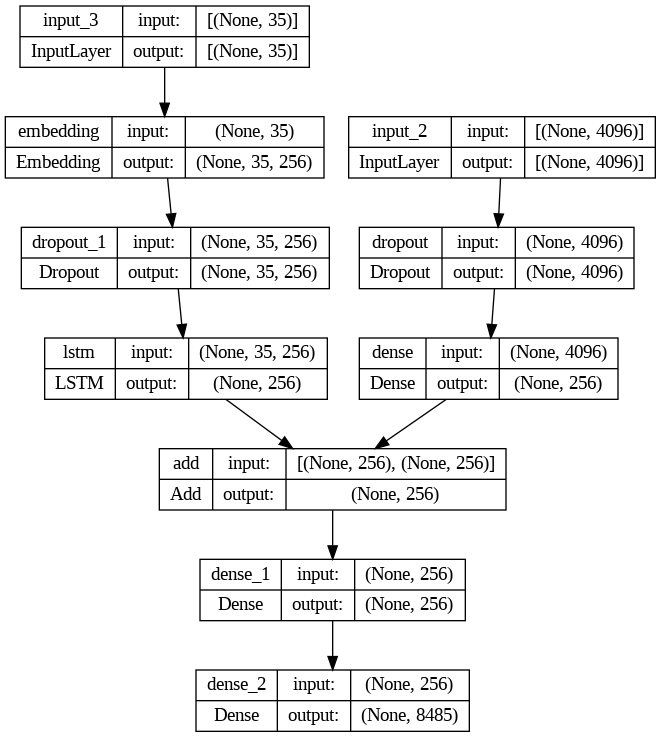

In [20]:
model = Model(inputs = [input_1, input_2], outputs = output) # Creating the final Model with input_1 and input_2 as the inputs and output as the output.
model.compile(loss="categorical_crossentrophy", optimizer = "adam", metrics=["accuracy"]) # Compiling the model displaying the loss funciton and the accuracy

# Plotting the trained model
plot_model(model, show_shapes = "True") # show_shapes = True, is an argument to display the shapes of the outputs of each layer in the plot. 



---



---



#19. Training the Created Model


In [ ]:
epochs = 40
batch = 32
steps = len(train) // batch # 90% of the data divided by 32

for i in range(epochs):
  generator = data_generate(train, mapping, features, tokenizer, maximum_length,vocabulary_size, batch) # Passing the argument to the functions
  model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1) # The model is trained using the "fit" method with the generator as input and the number of epochs set to 1, the number of steps per epoch set to "steps" and verbosity set to 1.

In [ ]:
# model saving for later use
model.save(os.path.join(BASE_DIR, "model2.h5")) # Will be save in the base directory

In [22]:
from keras.models import load_model
model = load_model(os.path.join(BASE_DIR, "model2.h5")) # Loading the saved model



---



---



#20. Generating Captions for the image

This is a function that takes in an integer and a tokenizer object and returns the word corresponding to the integer. The function uses a for loop to iterate through the word_index attribute of the tokenizer, which is a dictionary mapping words to their indices. If the index in the dictionary matches the input integer, the corresponding word is returned. If no match is found, the function returns None.

In [23]:
def index_to_word(integer, tokenizer): # all the words from the model will return index so needs to be converted to word
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

The below predict_caption function is used to predict a caption for an image by passing the image and a pre-trained image captioning model, along with a tokenizer and the maximum length of the caption. The function starts by setting the in_text to "<start>", which indicates the start of the predicted caption. The function then runs a for loop for the maximum length of the caption, where in each iteration, it converts the in_text into a sequence of integers using the tokenizer.texts_to_sequences() method, pads the sequence to the maximum length using pad_sequences(), predicts the next word using the image captioning model with model.predict(), gets the index of the word with the highest predicted probability using np.argmax(), converts the index to a word using index_to_word(), and appends the word to in_text. The loop breaks if the word is not found or if the word is "<end>", indicating the end of the predicted caption. The final predicted caption is returned by the function.
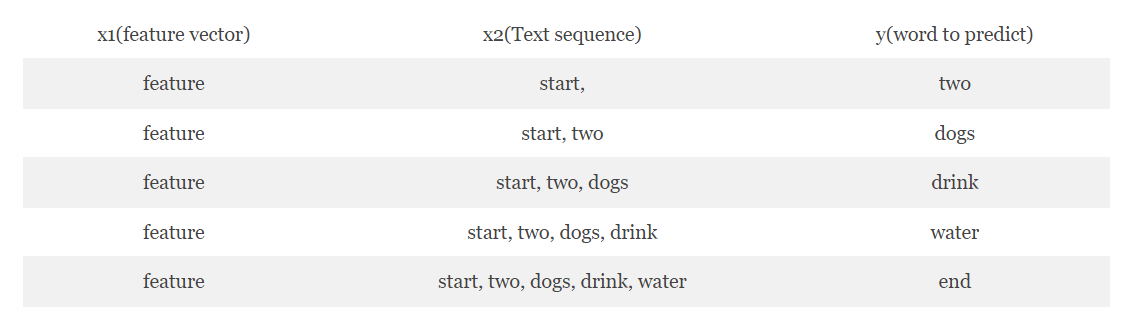

In [24]:
# Generate the captions
def predict_caption(model, image, tokenizer, maximum_length):
  in_text = "startseq" # Begining of the prediction will start form this
  for i in range(maximum_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0] # Converting the input text in_text into a sequence of integers, where each integer represents a word in the input text.
    # pad the sequence
    sequence = pad_sequences([sequence], maximum_length)
    # Predicting the next word
    yhat = model.predict([image, sequence], verbose=0) # yhat is the predicted output from the model after passing the 2 arguments, verbose is 0 meaning no output will be printed while precessing
    # Getting the index with higest probability
    yhat = np.argmax(yhat) # np.argmax returns the word with higest predicted probabilty to the next word in the sequence
    # Converting index to word
    word = index_to_word(yhat, tokenizer) # Converting the higest predicted probability integer back to word after checking it on the tozenizer function 
    # Stop if the word in not found
    if word is None:
      break
    # Appending the word as input for generating next word
    in_text = in_text + " " + word # 1.<start> word 2.<start> word word 3.<start> word word word
    # Break the loop if predicted word reached <end>
    if word == "endseq":
      break
  return in_text



---



---



#21. Bleu Score
The code below is used for evaluating the performance of the trained model. The nltk library's corpus_bleu function is used to calculate the BLEU score between the actual captions and predicted captions. The actual captions and predicted captions are stored in the "actual" and "predicted" lists respectively.

For each image in the test data, the actual captions are obtained from the "mapping" dictionary and the predicted caption is generated by calling the "predict_caption" function with the given model, image features, tokenizer, and maximum length. Then, the actual captions are split into a list of words, and the predicted caption is split into a list of words. The actual captions and predicted captions are then appended to the "actual" and "predicted" lists respectively.

Finally, the corpus_bleu function is called twice, with weights (1.0, 0, 0, 0) and (0.5, 0.5, 0, 0), to calculate BLEU-1 and BLEU-2 scores respectively. These scores indicate the degree of overlap between the actual captions and predicted captions.

In [25]:
from nltk.translate.bleu_score import corpus_bleu
# Validating with the test data separated above
actual, predicted = list(), list()
for key in tqdm(test): # Lopp through the test data
  # First getting its actual captions
  img_captions = mapping[key]
  # Getting the predicted caption for the image by our trained model
  y_predicted = predict_caption(model, features[key], tokenizer, maximum_length) # Passing the arguments fo predict_caption function whose output is saved in y_predicted
  actual_captions = [img_caption.split() for img_caption in img_captions ] # Gives all the captions of the realted image in order
  y_predicted = y_predicted.split()
  # Appending to the list
  actual.append(actual_captions)
  predicted.append(y_predicted)

# Bleu score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.541316
BLEU-2: 0.315592




---



---



#22. Testing with random image within the dataset
The code below defines a function generate_caption that takes in an image_name as an input, opens the image with the provided name and predicts the caption for the image. It then prints both the actual and predicted captions and shows the image.

First, it extracts the image_id by splitting the image_name at the '.' and taking the 0th index. It then sets the path to the image by joining the base directory with the Images folder and the image_name. The image is then opened using the Image module.

Next, it retrieves the actual captions for the image from the mapping dictionary and prints them, replacing the 'startseq' and 'endseq' with an empty string and stripping whitespaces.

Then it calls the predict_caption function and stores the result in y_predicted. The 'startseq' and 'endseq' are again replaced with an empty string and stripped of whitespaces. The predicted caption is then printed.

Finally, the image is displayed using the plt.imshow function and the axis are turned off using plt.axis("off").

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  image_id = image_name.split('.')[0] # Splitting the image with . and taking the 0th index
  img_path = os.path.join(BASE_DIR, "Images", image_name)
  image = Image.open(img_path) # Open the image form the path throught img_path
  img_captions = mapping[image_id]
  print('---------------------Actual---------------------')
  for img_caption in img_captions:
    img_caption = img_caption.replace("startseq", "").replace("endseq", "").strip()
    print(img_caption) # printing the real captions
  # predict the caption
  print()
  y_predicted = predict_caption(model, features[image_id], tokenizer, maximum_length)
  y_predicted = y_predicted.replace("startseq", "").replace("endseq", "").strip() # Removing the startseq and endseq
  print('--------------------Predicted--------------------')
  print(y_predicted) #printing the predicted caption
  plt.imshow(image) # plotting on the graph
  plt.axis("off") # Axis off on the graph

---------------------Actual---------------------
black dog and spotted dog are fighting
black dog and tri-colored dog playing with each other on the road
black dog and white dog with brown spots are staring at each other in the street
two dogs of different breeds looking at each other on the road
two dogs on pavement moving toward each other

--------------------Predicted--------------------
two dogs one with brown spots are playing with toy


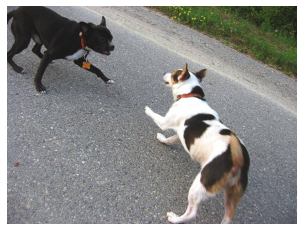

In [27]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
baby girl in an orange dress gets wet as she stands next to water sprinkler
blonde toddler wearing an orange dress is wet and standing beside sprinkler in yard
child in dress is looking at sprinkler
little girl in an orange dress is running through the sprinkler in the yard
"on wet grass little blond girl in orange dress plays in sprinkler ."

--------------------Predicted--------------------
little girl in pink dress plays with way


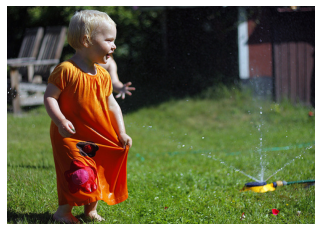

In [30]:
generate_caption("3767841911_6678052eb6.jpg")

---------------------Actual---------------------
girl dives into the water while another girl watches her
girl in black two-piece is leaping into the water
woman in bikini jumping off dock into lake
woman in black two-piece bathing suit jumping into green water
woman in black swimsuit is jumping in lake

--------------------Predicted--------------------
boy in black swimsuit jumping into the water


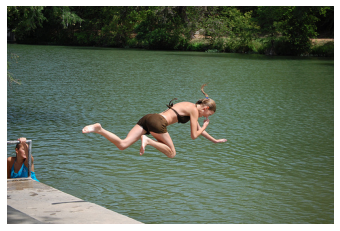

In [31]:
generate_caption("3758787457_1a903ee1e9.jpg")



---



---



#23. Predicting caption for a new image
The below code is for generating caption for a new image. First it loads the pre-trained VGG16 model, the extracted features, tokenizer, and a trained captioning model. The generate_caption function takes the trained captioning model, tokenizer, and image feature and outputs a predicted caption for the image. The new_image function takes an image path and loads the new image, processes it, and passes it through the VGG16 model to extract image features. Finally, the processed new image features are passed to the generate_caption function to get the predicted caption for the image.





In [42]:
# Load the pre-trained VGG16 model
model_vgg = VGG16()
model_vgg = Model(inputs=model_vgg.inputs, outputs=model_vgg.layers[-2].output) # Restructuring the model and removing the last layer as its not required for this project


with open (os.path.join(BASE_DIR, "Extracted_Features.pkl"), "rb") as f:
  features = pickle.load(f) # Features Loaded

with open(os.path.join(BASE_DIR, "TTT.pkl"), "rb") as t:
  tokenizer = pickle.load(t) # Tokenizer loaded

model = load_model(os.path.join(BASE_DIR, "model2.h5")) # Model Loaded

# Define a function to generate captions for a given image
def generate_caption(model, tokenizer, image, maximum_length=34):
    in_text = 'startseq' # Predicted caption will begin with this
    for i in range(maximum_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0] # Converting the input text in_text into numerical sequences that can be fed into the model. 
        sequence = pad_sequences([sequence], maxlen=35) 
        yhat = model.predict([image,sequence], verbose=0) # Generating predicition for the new image, taking 2 arrays first is image feature extracted from pre trained model and second is the sequence of words encoded as integers
        yhat = np.argmax(yhat) # Chossing the integer with higest predicted probabilty
        word = tokenizer.index_word[yhat] # passing yhat to index_to_word fucntion which returns word if the integer and index is matched
        in_text = in_text + ' ' + word
        if word == 'endseq':
            break
    final_caption = in_text.split() # Splitting the in_text string on spaces into a list of words.
    final_caption = final_caption[1:-1] # Printing the sliced string. Basically removing the start and end seq
    final_caption = " ".join(final_caption)
    return final_caption

# Load an image to generate captions for
def new_image (img_path): # Takes the new image path and does the following processing
  image = load_img(img_path, target_size=(224, 224)) # Loading the image with the given size
  plt.imshow(image)  # plotting the image 
  plt.axis("off") # axis set if off
  plt.show()

  image = img_to_array(image) # Converting the PIL image to numpy array to be trained on a deep learning model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # Reshaping the image into 4D tensor, this reshaping step is required so that the image data can be passed as input to the VGG16 model for feature extraction.
  image = preprocess_input(image) # Preprocessing the image before feeding it into the pre-trained cnn model
  image_feature = model_vgg.predict(image) # THe reshaped image is passed through predict() to extract the feature vector which stored in image_features
  image_id = os.path.basename(img_path).split(".")[0]

  # Generate captions for the image
  caption = generate_caption(model, tokenizer, image_feature)  # Passing the arguments of the new image after its preprocessing
  print("\n Predicted Caption:\n", caption)
  print("\n")

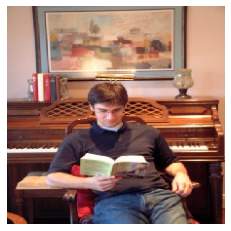

1/1 [==============================] - 1s 612ms/step

 Predicted Caption:
 man sitting at table with his hands over box




In [45]:
new_image("/content/drive/MyDrive/1920465.jpg")

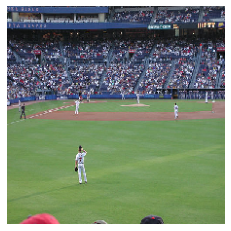

1/1 [==============================] - 1s 682ms/step

 Predicted Caption:
 baseball player in red uniform is sliding down the field




In [47]:
new_image("/content/drive/MyDrive/134206.jpg")

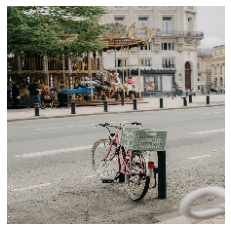

1/1 [==============================] - 1s 1s/step

 Predicted Caption:
 man and woman are walking down street lined with buildings




In [49]:
new_image("/content/drive/MyDrive/1.jpg")

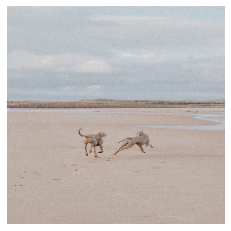

1/1 [==============================] - 1s 962ms/step

 Predicted Caption:
 dog runs along beach




In [50]:
new_image("/content/drive/MyDrive/2.jpg")

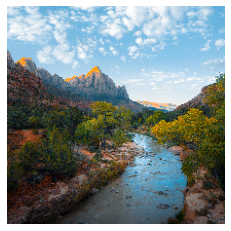

1/1 [==============================] - 1s 638ms/step

 Predicted Caption:
 two people walking along the water




In [51]:
new_image("/content/drive/MyDrive/11.jpg")

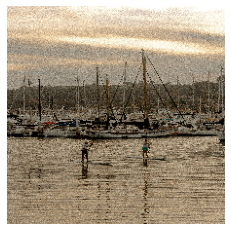

1/1 [==============================] - 1s 642ms/step

 Predicted Caption:
 man and woman are standing on step swing with other and other people




In [52]:
new_image("/content/drive/MyDrive/6.jpg")

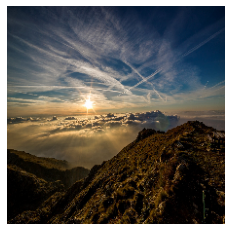

1/1 [==============================] - 1s 1s/step

 Predicted Caption:
 two people walking on mountain




In [57]:
new_image("/content/drive/MyDrive/12.jpg")